In [86]:
import pandas as pd
import pycountry_convert as pc

# Import libraries
import numpy as np
import os
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import shap
import xgboost as xgb

In [87]:
# Define data folder
data_folder = "./DASS_data"
dataset = pd.read_csv("./DASS_data/data.csv", delimiter='\t', on_bad_lines='skip')

In [88]:
missing_values = dataset.isna().sum()
print(missing_values)

Q1A               0
Q1I               0
Q1E               0
Q2A               0
Q2I               0
              ...  
race              0
voted             0
married           0
familysize        0
major         11425
Length: 172, dtype: int64


In [89]:
# Drop multiple columns in-place
dataset.drop(["major"], axis=1, inplace=True)

In [90]:
# Define the questions contributing to each score
depression_questions = ['Q3A', 'Q5A', 'Q10A', 'Q13A', 'Q16A', 'Q17A', 'Q21A', 'Q24A', 'Q26A', 'Q31A', 'Q34A', 'Q37A', 'Q38A', 'Q42A']
anxiety_questions = ['Q2A', 'Q4A', 'Q7A', 'Q9A', 'Q15A', 'Q19A', 'Q20A', 'Q23A', 'Q25A', 'Q28A', 'Q30A', 'Q36A', 'Q40A', 'Q41A']
stress_questions = ['Q1A', 'Q6A', 'Q8A', 'Q11A', 'Q12A', 'Q14A', 'Q18A', 'Q22A', 'Q27A', 'Q29A', 'Q32A', 'Q33A', 'Q35A', 'Q39A']

# Identify columns that end with 'A'
columns_to_update = [col for col in dataset.columns if col.endswith('A')]
print(columns_to_update)

# Add 1 to each of these columns
for col in columns_to_update:
    dataset[col] = dataset[col] - 1

# Calculate the Depression, Anxiety, and Stress scores
dataset['Depression_Score'] = dataset[depression_questions].sum(axis=1)
dataset['Anxiety_Score'] = dataset[anxiety_questions].sum(axis=1)
dataset['Stress_Score'] = dataset[stress_questions].sum(axis=1)

['Q1A', 'Q2A', 'Q3A', 'Q4A', 'Q5A', 'Q6A', 'Q7A', 'Q8A', 'Q9A', 'Q10A', 'Q11A', 'Q12A', 'Q13A', 'Q14A', 'Q15A', 'Q16A', 'Q17A', 'Q18A', 'Q19A', 'Q20A', 'Q21A', 'Q22A', 'Q23A', 'Q24A', 'Q25A', 'Q26A', 'Q27A', 'Q28A', 'Q29A', 'Q30A', 'Q31A', 'Q32A', 'Q33A', 'Q34A', 'Q35A', 'Q36A', 'Q37A', 'Q38A', 'Q39A', 'Q40A', 'Q41A', 'Q42A']


In [91]:
# Define functions to categorize the scores
def categorize_depression(score):
    if score <= 9:
        return 0
    elif score <= 13:
        return 1
    elif score <= 20:
        return 2
    elif score <= 27:
        return 3
    else:
        return 4

def categorize_anxiety(score):
    if score <= 7:
        return 0
    elif score <= 9:
        return 1
    elif score <= 14:
        return 2
    elif score <= 19:
        return 3
    else:
        return 4

def categorize_stress(score):
    if score <= 14:
        return 0
    elif score <= 18:
        return 1
    elif score <= 25:
        return 2
    elif score <= 33:
        return 3
    else:
        return 4

In [92]:
# Apply the categorization functions
dataset['Depression_Level'] = dataset['Depression_Score'].apply(categorize_depression)
dataset['Anxiety_Level'] = dataset['Anxiety_Score'].apply(categorize_anxiety)
dataset['Stress_Level'] = dataset['Stress_Score'].apply(categorize_stress)

In [93]:
anxiety_data = dataset.drop(['Depression_Level', 'Stress_Level', 'Depression_Score', 'Stress_Score'], axis=1)

In [94]:
# Step 1: Identify columns ending with 'E'
time_columns = [col for col in anxiety_data.columns if col.endswith('E')]

# Step 2: Determine the 95th percentile value for each time column
percentile_95 = anxiety_data[time_columns].quantile(0.99)

# Step 3: Filter out rows with extreme values in any of the time columns
for col in time_columns:
    cutoff_value = 100000
    anxiety_data = anxiety_data[dataset[col] <= cutoff_value]

In [95]:
def encode_country(row):
    # Encode country into three major regions (east, west, other)
    country_code = row["country"]
    try:
        if country_code and country_code != "NONE":
            continent_name = pc.country_alpha2_to_continent_code(country_code)
            if continent_name == "AS":
                region_name = "east"
            elif continent_name in ["NA", "EU", "OC"]:
                region_name = "west"
            else:
                region_name = "other"
        else:
            region_name = ""
    except:
        region_name = ""
    return region_name
    
def encode_continent(row):
    # Encode country into three major regions (east, west, other)
    country_code = row["country"]
    try:
        if country_code and country_code != "NONE":
            continent_name = pc.country_alpha2_to_continent_code(country_code)
        else:
            continent_name = ""
    except:
        continent_name = ""
    return continent_name

def encode_age(row):
    # Encode age into groups
    age = int(row['age'])
    if age < 18:
        agegroup = 0
    elif age < 28:
        agegroup = 1
    elif age < 38:
        agegroup = 2
    elif age < 48:
        agegroup = 3
    elif age < 58:
        agegroup = 4
    elif age < 68:
        agegroup = 5
    else:
        agegroup = 6
    return agegroup

In [96]:
anxiety_data["agegroup"] = dataset.apply(lambda row: encode_age(row), axis=1)
anxiety_data["continent"] = dataset.apply(lambda row: encode_continent(row), axis=1)
anxiety_data["region"] = dataset.apply(lambda row: encode_country(row), axis=1)

In [97]:
# Filter data
anxiety_data.drop(anxiety_data[(anxiety_data['gender'] == 0) | (anxiety_data['gender'] == 3)].index, inplace=True)  # Male and females only
anxiety_data[anxiety_data['age'] >= 18]  # Adults only
anxiety_data = anxiety_data[anxiety_data['region'] != ""]  # Must have region
anxiety_data = anxiety_data.dropna()

# Remove data with countries that have strict data privacy laws (for public use only)
# Define the list of countries to exclude
countries_to_exclude = ["CH", "IN", "JA", "AU"]
# Filter the dataset to exclude the specified countries and continent
anxiety_data = anxiety_data[(anxiety_data['continent'] != "EU") & ~anxiety_data['country'].isin(countries_to_exclude)]

In [98]:
for col in anxiety_data.columns:
    if "TIPI" in col or "VCL" in col:
        anxiety_data = anxiety_data.drop([col], axis=1)
    elif col[0] == "Q" and (col[-1] == "E" or col[-1] == "I"):
        anxiety_data = anxiety_data.drop([col], axis=1)

In [99]:
# Define data folder
seed = 100
data_folder = "./DASS_data"

features_dataframe = anxiety_data.drop(['Anxiety_Level', 'Anxiety_Score'], axis=1)
features_dataframe.to_csv(os.path.join(data_folder, "original_features.csv"), index=None)

In [100]:
def preprocess(dataframe):
    
    anxiety_level_0 = dataframe[dataframe['Anxiety_Level'] == 0]
    anxiety_level_1 = dataframe[dataframe['Anxiety_Level'] == 1]
    anxiety_level_2 = dataframe[dataframe['Anxiety_Level'] == 2]
    anxiety_level_3 = dataframe[dataframe['Anxiety_Level'] == 3]
    anxiety_level_4 = dataframe[dataframe['Anxiety_Level'] == 4]
    
    # Upsample the minority classes
    anxiety_level_0_upsampled = resample(anxiety_level_0, replace=True, n_samples=len(anxiety_level_4.index), random_state=seed)
    anxiety_level_1_upsampled = resample(anxiety_level_1, replace=True, n_samples=len(anxiety_level_4.index), random_state=seed)
    anxiety_level_2_upsampled = resample(anxiety_level_2, replace=True, n_samples=len(anxiety_level_4.index), random_state=seed)
    anxiety_level_3_upsampled = resample(anxiety_level_3, replace=True, n_samples=len(anxiety_level_4.index), random_state=seed)
    
    anxiety_data_upsampled = pd.concat([anxiety_level_0_upsampled, anxiety_level_1_upsampled, anxiety_level_2_upsampled, anxiety_level_3_upsampled, anxiety_level_4])
    anxiety_data = anxiety_data_upsampled.reset_index(drop=True)
    
    labels_dataframe = anxiety_data[['Anxiety_Level']].copy()
    features_dataframe = anxiety_data.drop(['Anxiety_Level', 'Anxiety_Score'], axis=1)
    features_dataframe.to_csv(os.path.join(data_folder, "original_features.csv"), index=None)
    
    # z-score normalization
    def z_score_norm(row, col, mean, stdev):
        z_score = (float(row[col]) - mean) / stdev
        return float(z_score)
    
    # One-hot encode gender and region
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder()
    
    # Label encode the target
    label_encoder = LabelEncoder()
    dataframe['Anxiety_Level'] = label_encoder.fit_transform(dataframe['Anxiety_Level'])
    
    # Gender
    gender = label_encoder.fit_transform(features_dataframe["gender"])
    gender = pd.DataFrame(gender)
    gender = pd.DataFrame(onehot_encoder.fit_transform(gender).toarray())
    gender.columns = ["gender_m", "gender_f"]
    
    # Region
    region = label_encoder.fit_transform(features_dataframe["region"])
    region = pd.DataFrame(region)
    region = pd.DataFrame(onehot_encoder.fit_transform(region).toarray())
    region.columns = ["region_other", "region_east", "region_west"]
    
    # Combine and remove original columns
    features_dataframe = features_dataframe.drop(["gender", "country", "region", "agegroup", "continent"], axis=1)
    features_dataframe = pd.concat([features_dataframe, gender, region], axis=1)
    
    # One-hot encode question answers
    for col in features_dataframe.columns:
        if col[0] == "Q" and col[-1] == "A":
            temp = label_encoder.fit_transform(features_dataframe[col])
            temp = pd.DataFrame(temp)
            temp = pd.DataFrame(onehot_encoder.fit_transform(temp).toarray())

            col_names = []
            for c in temp.columns:
                col_names.append("{0}_{1}".format(col, c))
            temp.columns = col_names

            features_dataframe = features_dataframe.drop([col], axis=1)
            features_dataframe = pd.concat([features_dataframe, temp], axis=1)
    
    # Normalize numerical columns (Use z-score)
    mean = features_dataframe["age"].mean()
    stdev = features_dataframe["age"].std()
    features_dataframe["age_norm"] = features_dataframe.apply(
                    lambda row: z_score_norm(row, "age", mean, stdev), axis=1)
    features_dataframe = features_dataframe.drop(["age"], axis=1)
    

    return features_dataframe, labels_dataframe

In [101]:
# Split into features and labels, save as CSV
features_df, labels_df = preprocess(anxiety_data)

features_df.to_csv(os.path.join(data_folder, "features.csv"), index=None)
labels_df.to_csv(os.path.join(data_folder, "labels.csv"), index=None)

In [102]:
from mrmr import mrmr_classif


train_feats = pd.read_csv(os.path.join(data_folder, "features.csv"))
train_feats = train_feats.drop(["age_norm", "gender_m", "gender_f", "region_other", "region_east", "region_west"], axis=1)  # Comment this line to include demographics
labels = pd.read_csv(os.path.join(data_folder, "labels.csv"))

labels = labels["Anxiety_Level"]

selected_features = mrmr_classif(X=train_feats, y=labels, K=10)
print(selected_features)

100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

['Q28A_0', 'Q30A_1', 'Q7A_0', 'Q36A_0', 'Q40A_3', 'Q4A_0', 'Q20A_3', 'Q20A_0', 'Q41A_0', 'Q9A_3']


In [103]:
# Not one-hot encoded dataset
train_feats = anxiety_data # Using sample dataset. Change the file name accordingly if using another dataset.
train_feats = train_feats.drop(["country","gender","age","agegroup","continent","region","Anxiety_Score", "Anxiety_Level"], axis=1)

labels = anxiety_data["Anxiety_Level"]

# print(MRMR(train_feats.to_numpy(), labels.to_numpy().ravel(), show_top)) # The customized function approach
selected_features = mrmr_classif(X=train_feats, y=labels, K=10) # The mrmr library approach
print(selected_features)

100%|██████████| 10/10 [00:01<00:00,  5.89it/s]

['Q28A', 'Q20A', 'Q40A', 'Q7A', 'Q36A', 'Q9A', 'Q4A', 'Q41A', 'Q30A', 'Q25A']


In [104]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# Load the dataset
X = pd.read_csv(os.path.join(data_folder, "original_features.csv"))
y = pd.read_csv(os.path.join(data_folder, "labels.csv"))
for column in X.columns:
    if "A" not in column:
        X.drop([column], axis=1, inplace=True)

print(X.shape, y.shape)


(57310, 42) (57310, 1)


In [105]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(45848, 42) (11462, 42) (45848, 1) (11462, 1)


In [130]:
model = RandomForestClassifier(n_estimators=100,random_state=1200)
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=1200)

In [131]:
# Create a SHAP explainer object
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X_train)
print(shap_values.shape)

(45848, 42, 5)


In [108]:
# Aggregate SHAP values across classes and samples
shap_values_abs = np.abs(shap_values).sum(axis=2).mean(axis=0)
print(shap_values_abs.shape)
# Ensure the resulting array is 1-dimensional
shap_values_abs = shap_values_abs.flatten()
print(shap_values_abs.shape)

(42,)
(42,)


In [122]:
# Create a DataFrame with feature names and their mean absolute SHAP values
shap_summary = pd.DataFrame({'feature': X_train.columns, 'shap_value': shap_values_abs})

# Sort the features by SHAP value in descending order
shap_summary = shap_summary.sort_values(by='shap_value', ascending=False)
print(shap_summary)

   feature  shap_value
39    Q40A    4.298428
27    Q28A    4.050959
19    Q20A    4.039627
35    Q36A    3.991885
8      Q9A    3.843652
1      Q2A    3.775841
24    Q25A    3.611151
29    Q30A    3.542590
6      Q7A    3.382264
3      Q4A    3.333368
18    Q19A    3.321617
40    Q41A    3.231723
14    Q15A    2.662340
22    Q23A    2.018979
11    Q12A    0.316510
32    Q33A    0.297381
28    Q29A    0.211006
16    Q17A    0.210732
15    Q16A    0.186314
7      Q8A    0.185749
13    Q14A    0.183726
10    Q11A    0.178794
31    Q32A    0.174237
9     Q10A    0.169922
25    Q26A    0.168748
20    Q21A    0.167213
5      Q6A    0.167172
21    Q22A    0.166876
0      Q1A    0.166135
23    Q24A    0.164635
38    Q39A    0.160434
36    Q37A    0.160065
17    Q18A    0.158369
26    Q27A    0.154011
37    Q38A    0.153848
34    Q35A    0.141371
33    Q34A    0.141179
30    Q31A    0.140829
41    Q42A    0.138926
12    Q13A    0.137645
4      Q5A    0.135488
2      Q3A    0.134664


In [123]:
# Select the top 10 features
top_features = shap_summary.head(10)['feature'].tolist()
print("Top Features based on SHAP values:", top_features)

Top Features based on SHAP values: ['Q40A', 'Q28A', 'Q20A', 'Q36A', 'Q9A', 'Q2A', 'Q25A', 'Q30A', 'Q7A', 'Q4A']


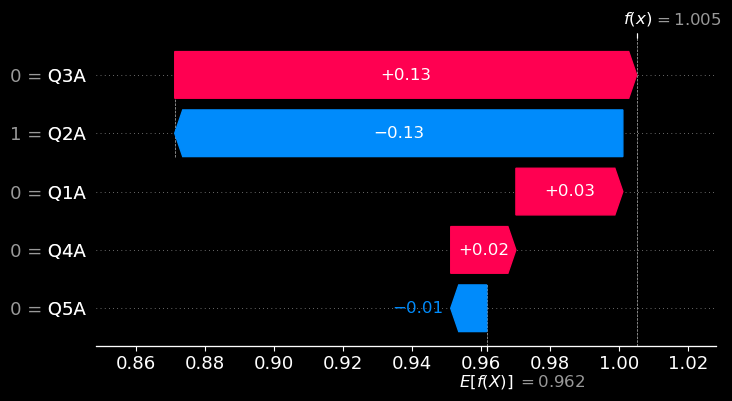

In [112]:
# Calculate SHAP values for a single prediction (first instance of the test set)
# shap_values_single = explainer.shap_values(X_test.iloc[0, :].values.reshape(1, -1))

# # For multi-class models, shap_values_single will be a list of arrays
# # Here, we choose the SHAP values for the specific class (e.g., class 0)
# shap_values_single_class = shap_values_single[0][0]

# # Create a waterfall plot for the first instance and specific class
# shap.waterfall_plot(shap.Explanation(values=shap_values_single_class, 
#                                      base_values=explainer.expected_value[0], 
#                                      data=X_test.iloc[0, :], 
#                                      feature_names=X_test.columns.tolist()))

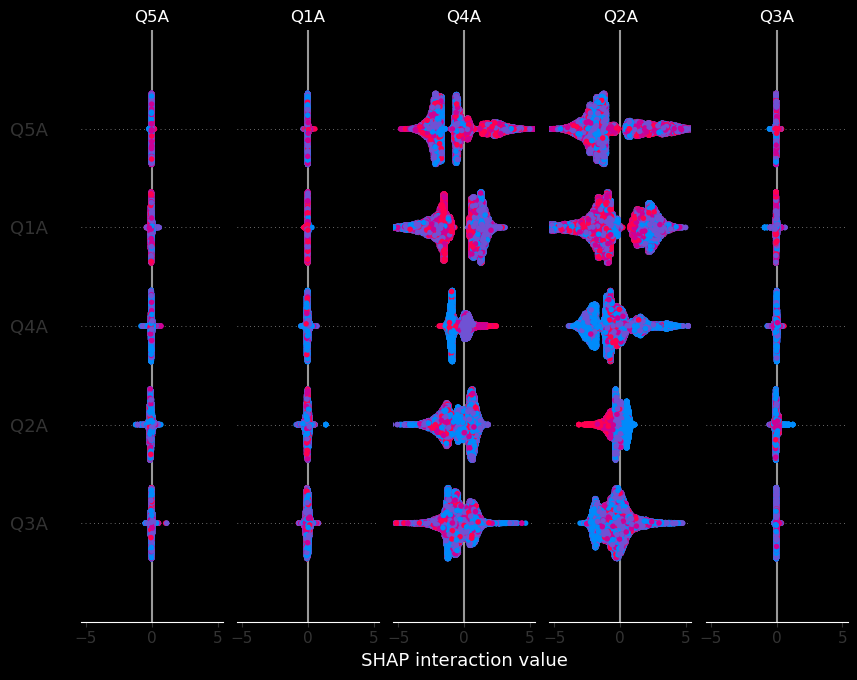

In [119]:
# Import libraries
import argparse
import pandas as pd
import numpy as np
import scipy
import os
import random
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, balanced_accuracy_score, confusion_matrix, 
                roc_auc_score, accuracy_score, roc_curve, RocCurveDisplay)

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import warnings

warnings.filterwarnings("ignore")
